In [19]:
# Dependencies

import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import xgboost as xgb
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve, auc,roc_auc_score,accuracy_score
warnings.filterwarnings("ignore")

In [20]:
# Authorization

client_credentials_manager = SpotifyClientCredentials(client_id='ENTER YOUR ID', client_secret='ENTER YOUR ID') 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 

In [40]:
def make_table (uri,genre):
    uri = uri
    username = uri.split(':')[2]
    playlist_id = uri.split(':')[4]
    results = sp.user_playlist(username, playlist_id)
    all_data = list(results.values())
    tracks_play = [list(x.values()) for x in list(all_data[12]["items"])]
    uri_ = [x[4]['uri'].split(':')[2] for x in tracks_play]
    data = pd.DataFrame(sp.audio_features(uri_))
    data['song_name'] = [x[4]['name'] for x in tracks_play]
    data['popularity'] = [x[4]['popularity'] for x in tracks_play]
    data['explicit'] = [0 if x[4]['explicit']==False else 1 for x in tracks_play]
    data.drop(['type','uri','type','analysis_url','duration_ms','mode','key','track_href','id'],axis=1,inplace=True)
    data.set_index('song_name',inplace=True)
    data['genre'] = [genre]*data.shape[0]
    return data

In [22]:
# Making the playlists and train and test sets

jazz = make_table('spotify:user:spotify:playlist:37i9dQZF1DWVqfgj8NZEp1','jazz')
opera = make_table('spotify:user:1280198655:playlist:3WGwsUISOFMfvSWAq5i2KR','opera')
reggae = make_table('spotify:user:spotify:playlist:37i9dQZF1DXbSbnqxMTGx9','reggae')
kpop = make_table('spotify:user:spotify:playlist:37i9dQZF1DX14fiWYoe7Oh','kpop')
blues = make_table('spotify:user:spotify:playlist:37i9dQZF1DXcnkReojaCnV','blues')
metal = make_table('spotify:user:spotify:playlist:37i9dQZF1DWWOaP4H0w5b0','metal')
total_data = pd.concat([jazz,opera,reggae,kpop,blues,metal])

le = preprocessing.LabelEncoder()
total_data['genre'] = le.fit_transform(total_data['genre'])
X_train, X_test, y_train, y_test = train_test_split(total_data.iloc[:,:-1], total_data.iloc[:,-1], test_size=0.20, random_state=23)

blues:blue  jazz:brown  kpop:orange  metal:red  opera:yellow  reggae:green


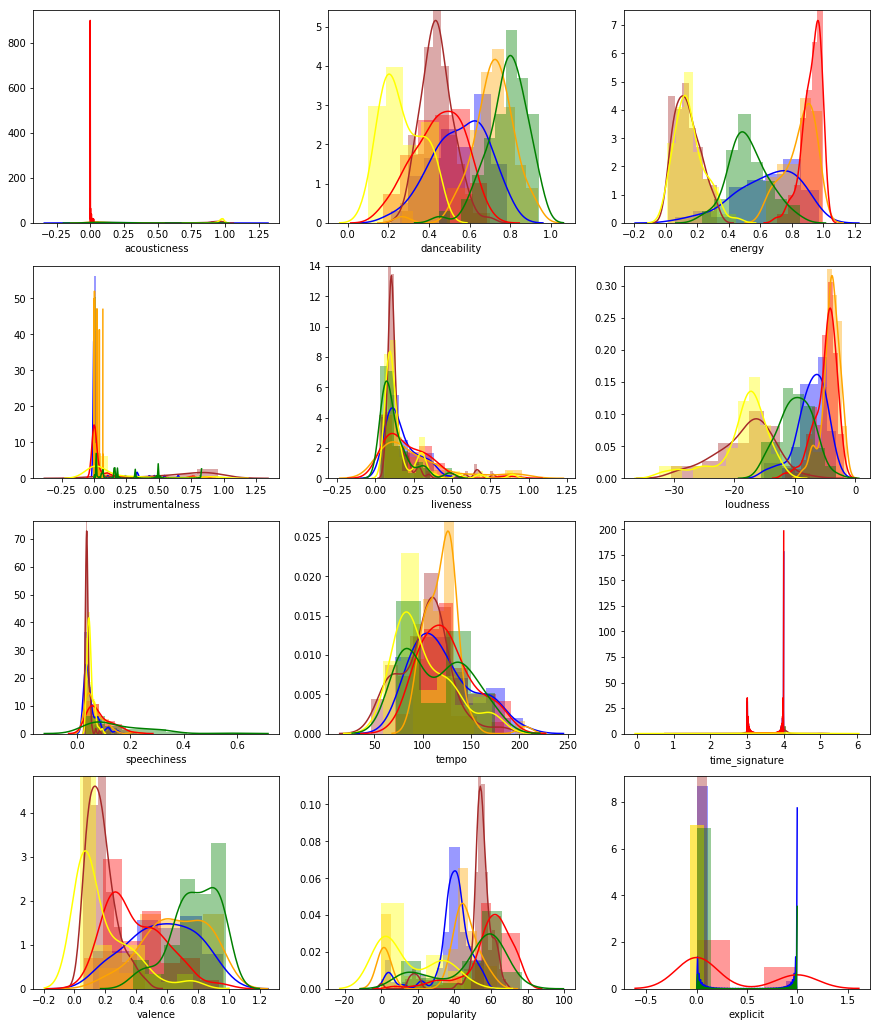

In [38]:
# Plotting the distributions of all the playlists

features = total_data.drop(['genre'],axis=1).columns
f, ax = plt.subplots(4,3)
f.set_figheight(18)
f.set_figwidth(15)
list_1 = [0]*3 + [1]*3  + [2]*3 + [3]*3 
list_2 = [0,1,2]*4
print ('blues:blue  jazz:brown  kpop:orange  metal:red  opera:yellow  reggae:green')
for z,c in zip([blues,jazz,kpop,metal,opera,reggae],['blue','brown','orange','red','yellow','green']):
    for x,y,feature in zip(list_1,list_2,features):
        sns.distplot(z[feature],ax=ax[x,y],color=c)
        #ax[x,y].axvline(z[feature].mean(),c=c)

In [24]:
# training model

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {
    'max_depth': 6,  # the maximum depth of each tree
    'eta': 0.01,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 6}  # the number of classes that exist in this datset
num_round = 60  # the number of training iterations
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

In [25]:
# accuracy 

accuracy = accuracy_score(y_test, best_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.52%


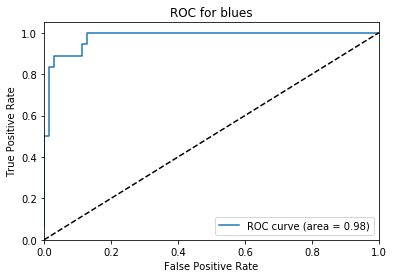

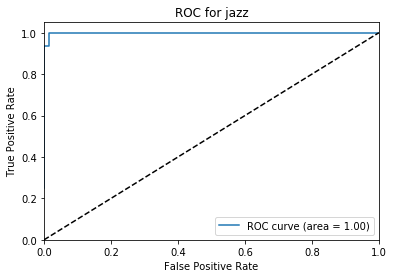

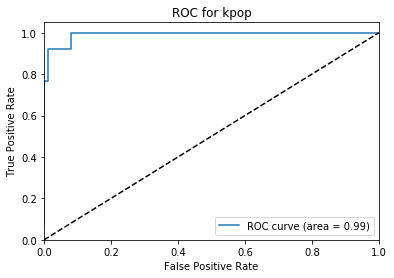

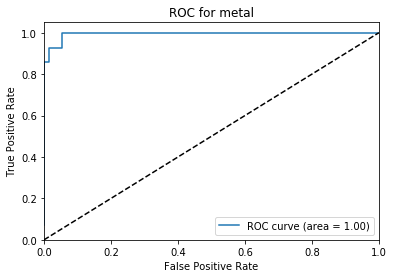

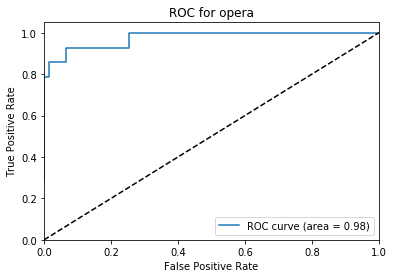

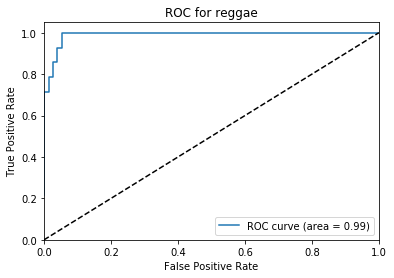

In [26]:
# ROC AUC for each genre

n_classes = 6
start = np.array([0]*n_classes*len(y_test)).reshape(len(y_test),n_classes)
for x,arr,z in zip(y_test.values,start,range(len(y_test))):
    start[z][x] = 1
    
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(start[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i,name in zip(range(n_classes),['blues','jazz','kpop','metal','opera','reggae']):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(name))
    plt.legend(loc="lower right")
    plt.show()

In [27]:
# Seeing what values model predicted wrongly

eval_model = pd.DataFrame(y_test)
eval_model['predictions'] = best_preds
eval_model[eval_model['genre']!=eval_model['predictions']]

,genre,predictions
song_name,,
I'll Keep Ramblin',0,3
I’m Getting Better (And I’m Feeling It Right Now),0,3
"La traviata / Act 1: ""Libiamo ne'lieti calici""",4,1
Taplow,1,0
Good Thing Going,5,2
여름날 (Hi Ya Ya) - Rearranged,2,0
"Rigoletto / Act 3: ""La donna è mobile""",4,0
"Take Me Home, Country Roads",5,0
Il barbiere di Siviglia (The Barber of Seville): Overture,4,1


Text(0.5,42,'Predicted values')

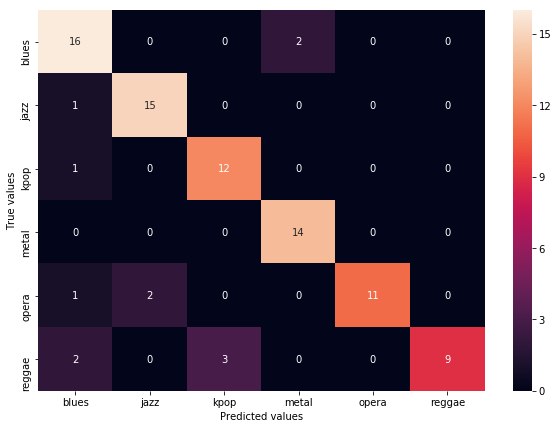

In [28]:
# clearer visualization

cm=confusion_matrix(y_test,best_preds)
df_cm = pd.DataFrame(cm, index = [i for i in ['blues','jazz','kpop','metal','opera','reggae']],
                  columns = [i for i in ['blues','jazz','kpop','metal','opera','reggae']])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True values')
plt.xlabel('Predicted values')